# Mapping atom analysis
Valid for experiments from 2025-04-30 until ...


In [677]:
date_filters = ["2025-09-10"]

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu
from IPython.display import display, HTML ## for large prints
import math
import itertools

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def average_over_measurement(measurements, history):
    iteration = len(history) // measurements
    mean_by_iteration = [np.mean(history[j * measurements:(j + 1) * measurements]) for j in range(iteration)]
    return mean_by_iteration


fnames = get_files_by_criteria(date_filters, # only find files from these date directories
                               name_filters=["GeneralVariableScan"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # if False, only return the name of the file, not the full path
                               print_filenames=True
)


only_show_i_greater_than = -1

print(f"found {len(fnames)} files")
for i,f in enumerate(fnames):
    if i > only_show_i_greater_than:
        try:
            ds = h5py.File(os.path.join(results, f))['datasets']
            scan_str = str_from_h5(ds['scan_variable1_name'])
            if str_from_h5(ds['scan_variable2_name']) != '':
                scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
            print(f"file {i} ({f}) scanned over "+scan_str)
        except:

            print(f"oops... something wrong with {f}")

found 18 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\01\000030289-GeneralVariableScan.h5) scanned over f_microwaves_m11_dds
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\01\000030289-GeneralVariableScan_microwave_map01_MWRFm11_scan_over_f_microwaves_m11_dds.h5) scanned over f_microwaves_m11_dds
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\02\000030290-GeneralVariableScan.h5) scanned over f_microwaves_m11_dds
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\02\000030290-GeneralVariableScan_microwave_map01_MWRFm11_scan_over_f_microwaves_m11_dds.h5) scanned over f_microwaves_m11_dds
file 4 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\03\000030291-GeneralVariableScan.h5) scanned over f_microwaves_m11_dds
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2025-09-10\03\000030291-GeneralVariableScan_microwave_map01_MWRFm11_s

## Combine files - Fitting resonance dip

experiment: microwave_map01_MWRFm11_experiment
override: {'dummy_variable':4,'target_780_QWP':15.0,'f_microwaves_m11_dds':331.914*MHz}
# of iterations:  50
iteration 34, no measurements
center=0.0007±0.0000, sigma=10000.0000±0.0000, depth=0.5788±0.0490


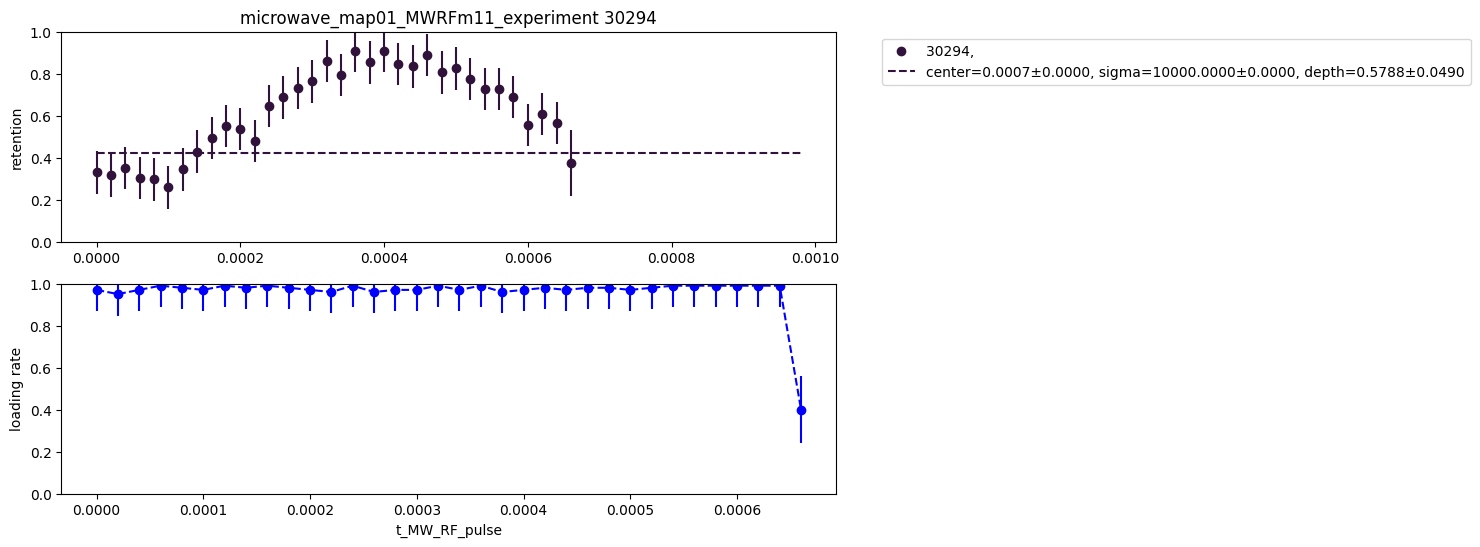

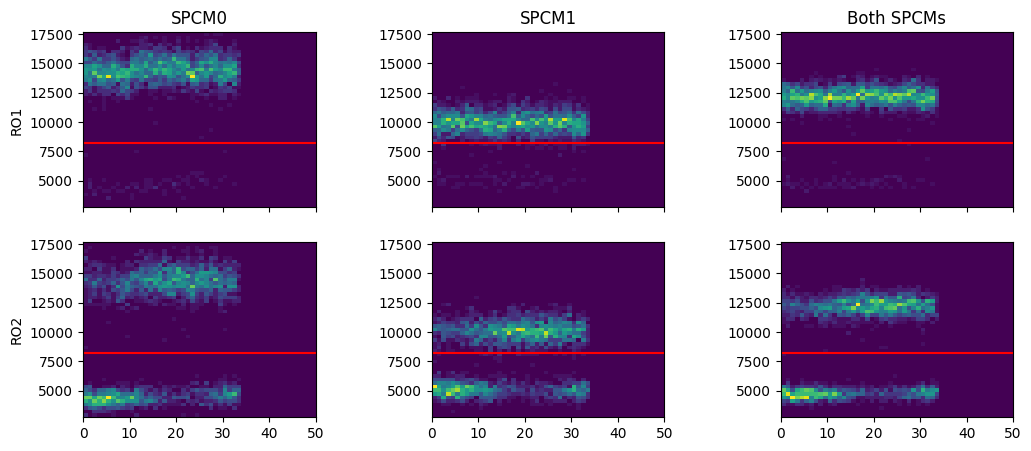

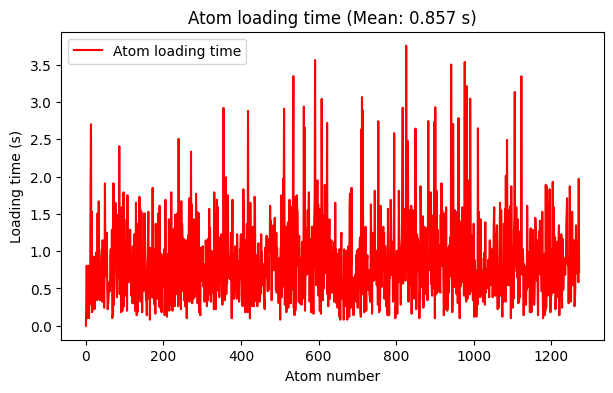

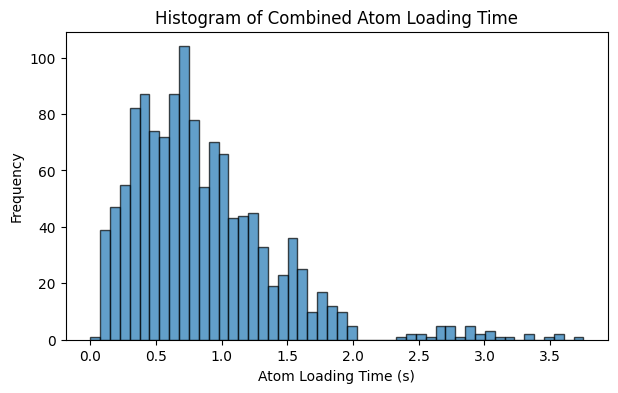

In [680]:
"""
With fitting the resonance for microwave scans

"""
### the file(s) to analyze:
file_indices = {
    10:'',
    # 20:'HWP=1.875, QWP=4.5',
    # 22:'HWP=1.875, QWP=3.5',
    # 36:'HWP=1.875, QWP=4.5',
    # 38:'HWP=0.5, QWP=4.5',
    # 38:'',
    # 40:'',
} 

# file_indices = {i: '' for i in range(10, 26, 2)}

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = True
is_it_a_peak = False ### use True if the resonance we are trying to fit shows as a peak. False for a dip resonance.

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(10, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''

all_atom_loading_times = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)

    all_atom_loading_times.append(Atom_loading_time)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}
            min_idx = np.argmin(retention_array)
            initial_center = scan_sequence1[min_idx]
            p0_dip = [initial_center, 10e3, 0.9] # [center, width, depth]

            max_idx = np.argmax(retention_array)
            initial_center = scan_sequence1[max_idx]
            p0_peak = [initial_center, 10e3, 0.9] # [center, width, hight]
            
            ### using a  Gaussian function for now:
            if is_it_a_peak:
                fit_dict = {
                    scan_variable1_name: {
                        'model': lambda x, center, sigma, depth: depth * np.exp(-((x - center)**2/(2*sigma**2))), ### use for resonance peaks
                        'p0': p0_peak,
                        'bounds': ([min(scan_sequence1), 0, 0.5], [max(scan_sequence1), np.inf, 1.0]),
                        'params': ['center', 'sigma', 'depth']
                    }
                }
            else:
                fit_dict = {
                    scan_variable1_name: {
                        'model': lambda x, center, sigma, depth: 1.0*(1 - depth * np.exp(-((x - center)**2/(2*sigma**2)))), ### use for resonance dips
                        'p0': p0_dip,
                        'bounds': ([min(scan_sequence1), 0, 0.5], [max(scan_sequence1), np.inf, 1.0]),
                        'params': ['center', 'sigma', 'depth']
                    }
                }
                

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, pcov = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                perr = np.sqrt(np.diag(pcov))  # Parameter uncertainties
                # fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2] ### without errors
                fit_str = ", ".join(f"{p}={v:.4f}±{e:.4f}" for p, v, e in zip(fit_dict[scan_variable1_name]['params'], popt, perr)) ### with errors
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            # ax_ret.grid(True)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()



#### Plot the combined Atom_loading_time values
## We can slice the array to separate iterations later, if we want.
combined_atom_loading_times = list(itertools.chain(*all_atom_loading_times))
mean_loading_time = np.mean(combined_atom_loading_times)
plt.figure(figsize=(7, 4))
plt.plot(combined_atom_loading_times, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
# plt.title(f"Combined Atom Loading Time for All Files")
plt.legend(loc='best')
plt.show()

# Plot the histogram of combined Atom_loading_time
plt.figure(figsize=(7, 4))
plt.hist(combined_atom_loading_times, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Atom Loading Time (s)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Combined Atom Loading Time")
plt.show()

## Combine files - Fitting Rabi oscillations

experiment: microwave_Rabi_2_experiment
override: {'dummy_variable':4,'t_MW_RF_pulse':14*us,'AY_volts_microwave':3.23*V,'t_microwave_00_pulse':6*us}
# of iterations:  200
iteration 173, no measurements
amplitude=0.4109, freq=108568.2990, phase=0.0000, offset=0.4238, t_decay=0.0005


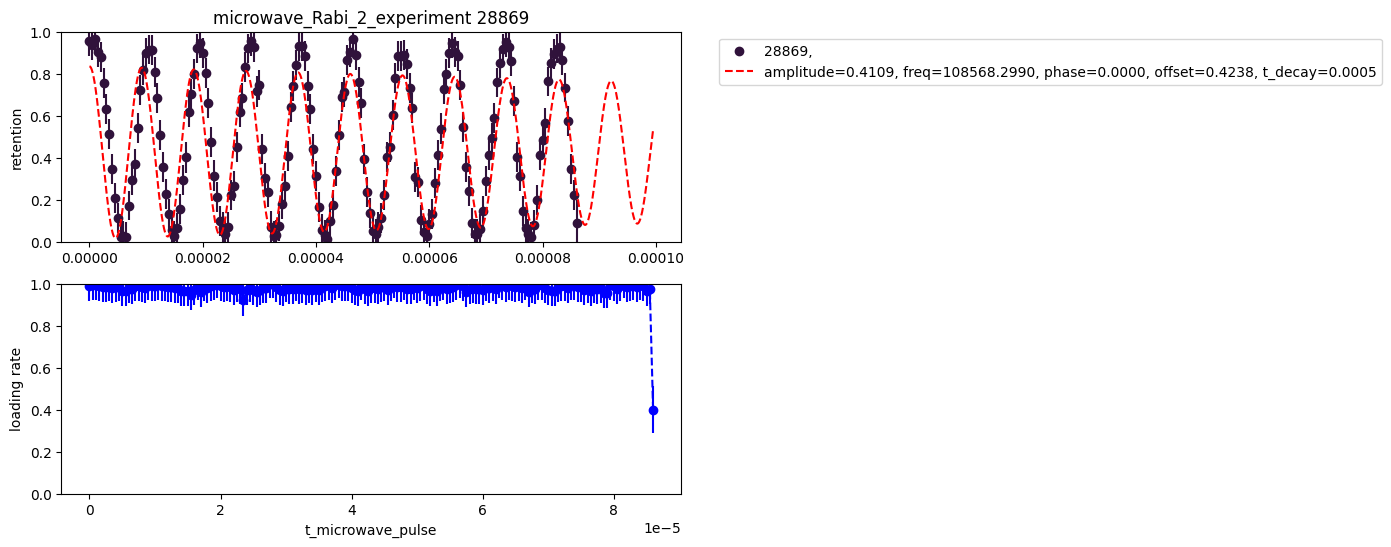

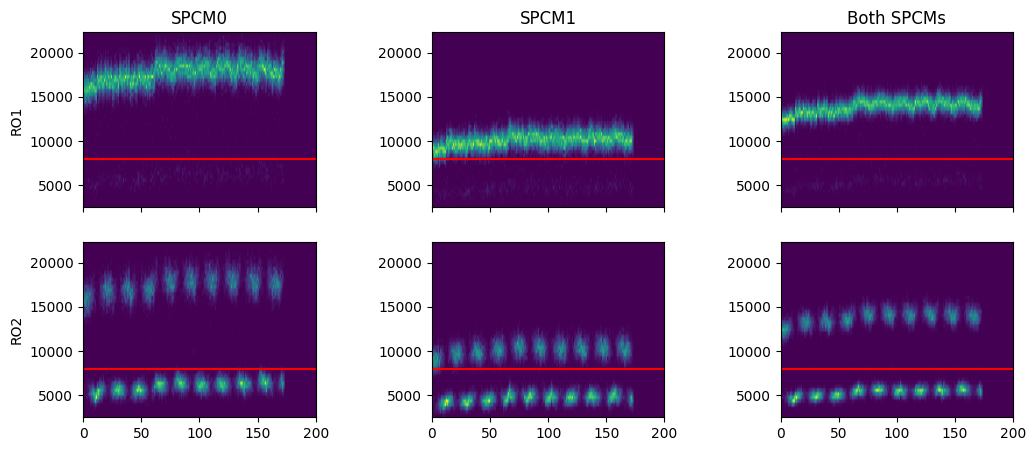

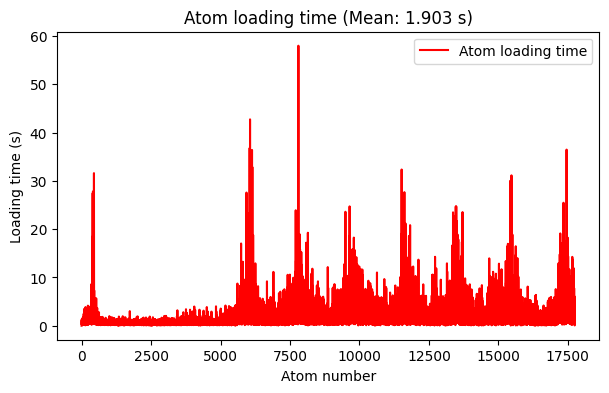

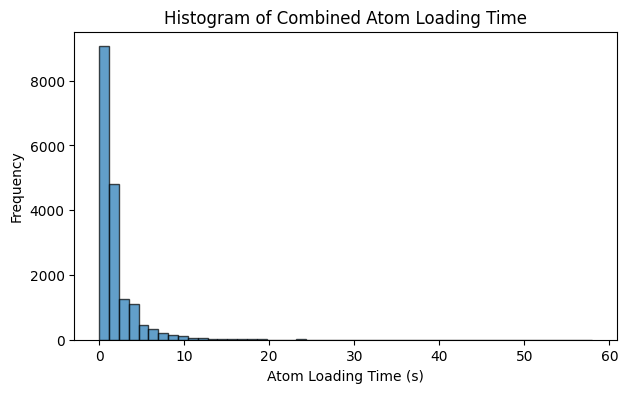

In [572]:
"""
With fitting Rabi oscillation

"""
### the file(s) to analyze:
file_indices = {
    59:'',
    # 12:'',
    # 48:''
} 

# file_indices = {i: '' for i in range(44, 103, 2)}

compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = False # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = True
custom_xlabel = True
merge_data = False # if True, the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = True

showhist_counts = False 

# for plotting
legend_vars =[]   #legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend
xform_and_label = {}
loc='best'
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=False, figsize=(8, 6))
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()


SPCM0_RO1_hists = []
SPCM0_RO2_hists = []
SPCM1_RO1_hists = []
SPCM1_RO2_hists = []
BothSPCMs_RO1_hists = []
BothSPCMs_RO2_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.array([])
merged_scan_sequence1 = np.array([])
merged_errs = np.array([])
rid_str = ''

all_atom_loading_times = []

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item   # idx - f_item = {f_idx: f_comment}
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(SPCM0_RO1)/n_measurements)
    print("# of iterations: ", iterations)

    all_atom_loading_times.append(Atom_loading_time)
    
    if otsu_threshold:
        thresh = threshold_otsu(BothSPCMs_RO1)
        print("threshold_otsu: ", thresh)
    else:
        cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    
    ### for plotting 
    ### xsteps_xform is a function that can transform scan_sequence1 for plotting. Here it is equal to identity, i.e. no change in scan_sequence1.
    if scan_variable1_name in xform_and_label and custom_xlabel:
        xsteps_xform, xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'], xform_and_label[scan_variable1_name]['xlabel'])
    else:
        xsteps_xform, xlabel = (lambda x: x, scan_variable1_name)
        

    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    
    ### get_loading_and_retention
    ### These array have length = iterations
    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=otsu_threshold)


    ### Necessary to analyze data with 2 scan_sequences
    ### reshaping each array into a 2D array with shape = shape, with order = 'F' (Fortran-style) to sort column by column
    
    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2

    
    ### show historam of first_shot and second_shot
    histMin = np.min([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot ## boundary for the histogram plots
    histMax = np.max([SPCM0_RO1, SPCM0_RO2, SPCM1_RO1, SPCM1_RO2])/t_SPCM_first_shot
    if showhist:
        SPCM0_RO1_hists.append(
            [np.histogram(SPCM0_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM0_RO2_hists.append(
            [np.histogram(SPCM0_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO1_hists.append(
            [np.histogram(SPCM1_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        SPCM1_RO2_hists.append(
            [np.histogram(SPCM1_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])
        
        BothSPCMs_RO1_hists.append(
            [np.histogram(BothSPCMs_RO1[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

        BothSPCMs_RO2_hists.append(
            [np.histogram(BothSPCMs_RO2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(histMin,histMax,50))[0]
                              for i in range(iterations)])

    
    ### plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)), retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=False)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            ### for fitting
            ### Auto-detect rough center from minimum retention
            fit_dict = {}
            # min_idx = np.argmin(retention_array)
            # initial_center = scan_sequence1[min_idx]
            # p0 = [initial_center, 10e3, 0.9] # [center, width, depth]

            p0 = [0.48, 1e5, 0, 0.5, 0.5] # ['amplitude', 'freq', 'phase', 'offset','t_decay']
            
            ### using a  Gaussian function for now:
            fit_dict = {
                scan_variable1_name: {
                    # 'model': lambda t, center, sigma, depth: 0.80*(1 - depth * np.exp(-((t - center)**2/(2*sigma**2)))),
                    'model': lambda t, A, freq, phase, offset, t_decay: offset + A * np.exp(-t/t_decay) * np.cos(2*np.pi*freq * t + phase),
                    'p0': p0,
                    'bounds': ([0.4, 3e3, 0, 0.4, 0], [0.5, 2e5, 2*np.pi, 0.6, 10.0]),
                    'params': ['amplitude', 'freq', 'phase', 'offset','t_decay']
                }
            }

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                # ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='r',label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")


if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), sharex=True)  # 2 rows, 3 columns
    ax, ax2, ax3, ax4, ax5, ax6 = axes.ravel()  # Flatten the 2D axes array for easier unpacking

    ### Plot for SPCM0 RO1 in the 1st row, 1st column
    cax = ax.imshow(np.array(SPCM0_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax.set_ylabel("RO1")
    ax.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax.set_aspect('auto')
    ax.set_title("SPCM0")

    ### Plot for SPCM1 RO1 in the 1st row, 2nd column
    cax2 = ax2.imshow(np.array(SPCM1_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax2.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax2.set_aspect('auto')
    ax2.set_title("SPCM1")

    ### Plot for BothSPCMs RO1 in the 1st row, 3rd column
    cax3 = ax3.imshow(np.array(BothSPCMs_RO1_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax3.axhline(cutoff1 / t_SPCM_first_shot, color='red')
    ax3.set_aspect('auto')
    ax3.set_title("Both SPCMs")

    ### Plot for SPCM0 RO2 in the 2nd row, 1st column
    cax4 = ax4.imshow(np.array(SPCM0_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax4.set_ylabel("RO2")
    ax4.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax4.set_aspect('auto')

    ### Plot for SPCM1 RO2 in the 2nd row, 2nd column
    cax5 = ax5.imshow(np.array(SPCM1_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax5.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax5.set_aspect('auto')

    ### Plot for BothSPCMs RO2 in the 2nd row, 3rd column
    cax6 = ax6.imshow(np.array(BothSPCMs_RO2_hists[0]).transpose(), origin='lower', extent=[0, iterations, histMin, histMax])
    ax6.axhline(cutoff2 / t_SPCM_first_shot, color='red')
    ax6.set_aspect('auto')

    plt.subplots_adjust(hspace=0.2, wspace=0.5)
plt.show()



#### Plot the combined Atom_loading_time values
## We can slice the array to separate iterations later, if we want.
combined_atom_loading_times = list(itertools.chain(*all_atom_loading_times))
mean_loading_time = np.mean(combined_atom_loading_times)
plt.figure(figsize=(7, 4))
plt.plot(combined_atom_loading_times, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
# plt.title(f"Combined Atom Loading Time for All Files")
plt.legend(loc='best')
plt.show()

# Plot the histogram of combined Atom_loading_time
plt.figure(figsize=(7, 4))
plt.hist(combined_atom_loading_times, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Atom Loading Time (s)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Combined Atom Loading Time")
plt.show()




## Simple single file - Fitting Ramsey coherence measurement

experiment: microwave_Ramsey_00_experiment
override: {'dummy_variable':4,'t_microwave_pulse':3.1*us,'AY_volts_microwave':5.0*V,'f_microwaves_dds':(334.675)*MHz}
# of iterations:  150
amplitude=0.374168, offset=0.547400, phase=3.048446, T2s=0.001362, f_detuning=16345.887511


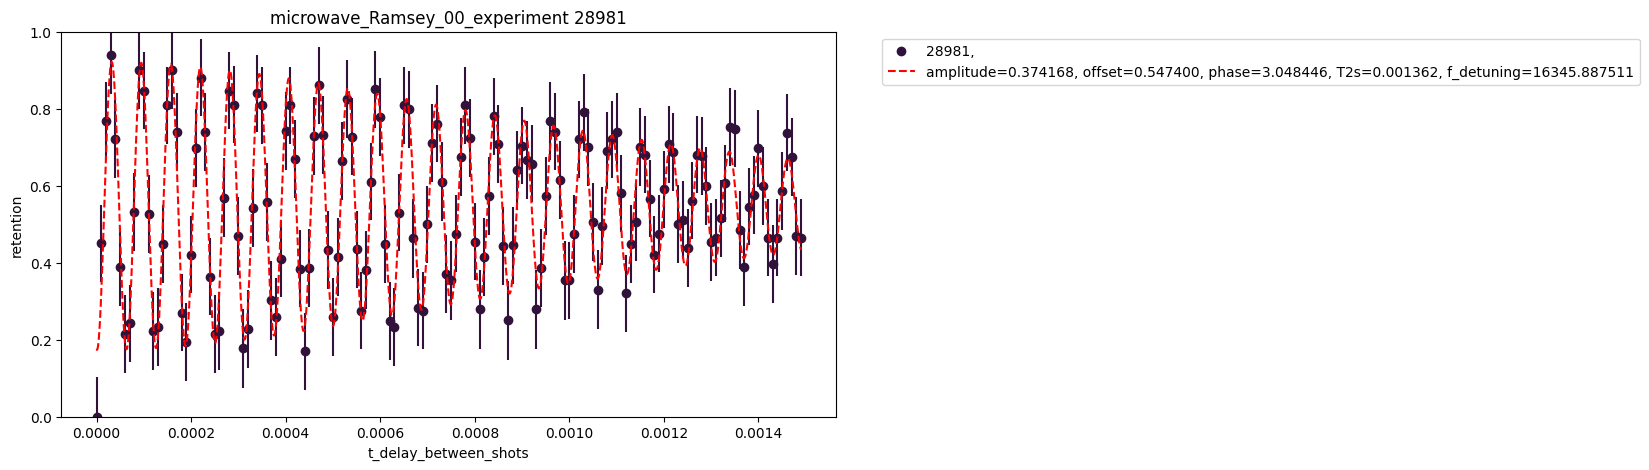

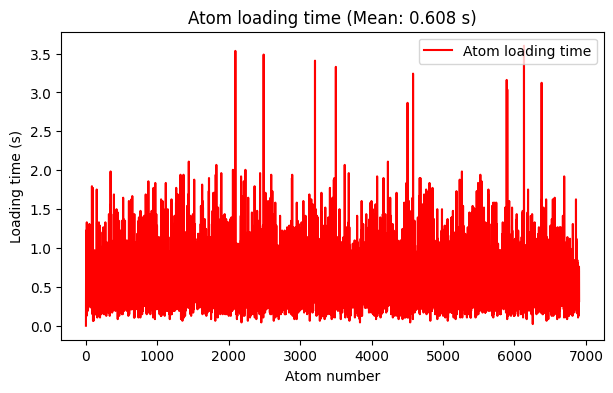

In [588]:
"""
Ramsey decay analysis
"""

file_indices = {
    7: '',
#     32: '',
#     34: '',
#     36: '',
#     38: '',
}

ret_cmap = mpl.colormaps['turbo']

for idx, f_item in enumerate(file_indices.items()):
    f_idx, f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)

    # ### use this to limit the number of iterations to analyze. Comment out otherwise:
    # max_iter = 100
    # scan_sequence1 = scan_sequence1[:max_iter]
    # BothSPCMs_RO1 = BothSPCMs_RO1[:max_iter * n_measurements]
    # BothSPCMs_RO2 = BothSPCMs_RO2[:max_iter * n_measurements]


    print("experiment:", experiment_function)
    print("override:", override_ExperimentVariables)

    iterations = len(scan_sequence1)
    print("# of iterations: ", iterations)

    cutoff1 = cutoff2 = single_atom_threshold * t_SPCM_first_shot

    xsteps_xform = lambda x: x
    xlabel = scan_variable1_name

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(
        BothSPCMs_RO1, BothSPCMs_RO2, n_measurements, iterations, cutoff1, otsu=False
    )
   
    shape = (len(scan_sequence2), len(scan_sequence1))
    retention_raveled = np.reshape(retention_array, shape, order='F')
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array, shape, order='F')
    loading_rate_raveled = np.reshape(loading_rate_array, shape, order='F')


    fig_ret, ax_ret = plt.subplots(figsize=(10, 5))

    for i, (retention, n_loaded, loading) in enumerate(zip(retention_raveled, n_atoms_loaded_raveled, loading_rate_raveled)):
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        mask = loading > 0
        xvals = xsteps_xform(scan_sequence1)[mask]
        yvals = retention[mask]
        yerrs = errs[mask]

        ax_ret.scatter(xvals, yvals, label=str(rid) + ', ' + f_comment, color=ret_cmap(idx / len(file_indices)))
        ax_ret.errorbar(xvals, yvals, yerrs, ls='none', color=ret_cmap(idx / len(file_indices)))
        ax_ret.set_ylim((0, 1))

        #### fitting:
        # omega_hfs = 2*np.pi*6.834e9
        # c = 3e8
        # Delta_D2 = 2*np.pi*c*(1/852e-9 - 1/780e-9)
        # Delta_D1 = 2*np.pi*c*(1/852e-9 - 1/795e-9)
        # Delta_eff = (2*Delta_D2 + Delta_D1)/3
        # eta = omega_hfs/Delta_eff
        # T_trap = 2.1e-3
        # kB_over_hbar = 1.31e11
        # delta_0 = eta* kB_over_hbar * T_trap

        # delta_synth = 2*np.pi*20*1e3
        # delta_B = 2*np.pi*1*1e3


        p0 = [0.43, 0.5, 3.14, 1.0e-3, +20000]  # guess: [A, offset, phase, T2s, f_detuning]
        bounds = ([0.3, 0.45, 2.2, 0.1e-3, 0], [0.6, 0.6, 2 * np.pi, 2e-3, 30000])
        model = lambda t, A, offset, phase, T2s, f_detuning: offset + A * (1+0.95*(t/T2s)**2)**(-3/2)*np.cos((2*np.pi*(f_detuning))*t - 3*np.arctan(0.97*t/T2s) + phase)
        params = ['amplitude', 'offset', 'phase', 'T2s', 'f_detuning']

        popt, _ = curve_fit(f=model, xdata=scan_sequence1, ydata=retention, p0=p0, bounds=bounds)
        fit_str = ", ".join(f"{p}={v:.6f}" for p, v in zip(params, popt))
        print(fit_str)

        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10 * len(scan_sequence1))
        hi_res_x_xform = xsteps_xform(hi_res_x)
        ax_ret.plot(hi_res_x_xform, model(hi_res_x, *popt), linestyle='--', label=fit_str, color='r')
        # ax_ret.plot(hi_res_x_xform, model(hi_res_x, *popt), linestyle='--', label=fit_str, color=ret_cmap(idx / len(file_indices)))

    ax_ret.set_xlabel(xlabel)
    ax_ret.set_ylabel("retention")
    ax_ret.set_title(experiment_function + ' ' + str(rid))
    ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
fig_ret.savefig("Ramsey.pdf", bbox_inches='tight')


#### Plot Atom_loading_time
mean_loading_time = np.mean(Atom_loading_time)
plt.figure(figsize=(7, 4))
plt.plot(Atom_loading_time, 'r-', label='Atom loading time')
plt.xlabel("Atom number")
plt.ylabel("Loading time (s)")
plt.title(f"Atom loading time (Mean: {mean_loading_time:.3f} s)") 
# plt.title(f"Combined Atom Loading Time for All Files")
plt.legend(loc='best')
plt.show()